<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/ML/notebooks/ch19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
plt.rcParams['font.sans-serif'] = ['DFKai-sb'] 
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df['target'] = iris['target']

In [4]:
X_cols = ['sepal width (cm)', 'petal length (cm)']
y_col = 'target'

In [5]:
X = df[X_cols]
y = df[y_col]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


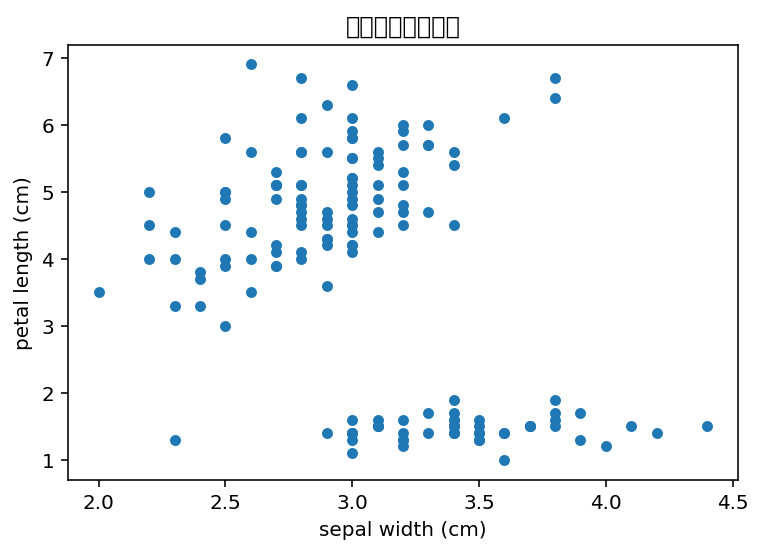

In [6]:
df.plot(kind='scatter', x='sepal width (cm)', y='petal length (cm)', 
        title='沒有目標值的輔助');

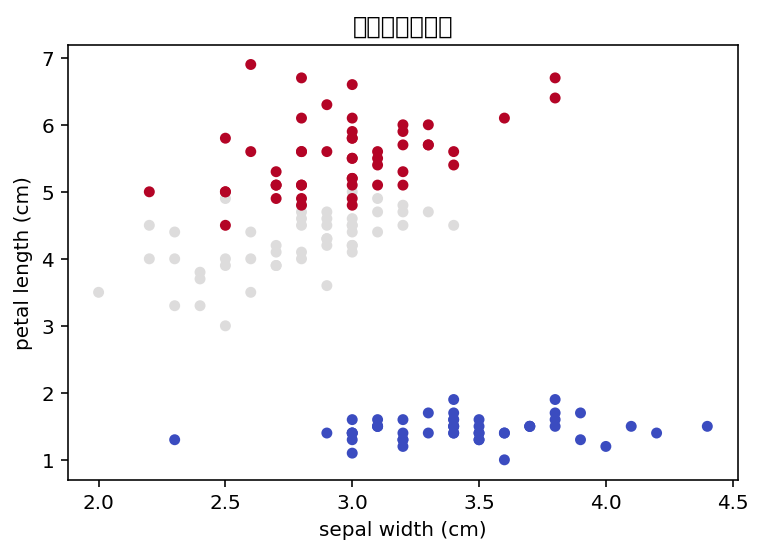

In [7]:
df.plot(kind='scatter', x='sepal width (cm)', y='petal length (cm)',
        c='target', cmap='coolwarm', colorbar=False,
        title='有目標值做輔助');

In [8]:
from sklearn.cluster import KMeans
kms = KMeans(n_clusters=3, random_state=42)
kms.fit(X, y)
print(kms.cluster_centers_)

[[2.75087719 4.32807018]
 [3.03255814 5.67209302]
 [3.428      1.462     ]]


In [9]:
pd.DataFrame(kms.transform(X)[:3], 
             columns=['集群0','集群1','集群2']).style.highlight_min(axis=1)

,集群0,集群1,集群2
0,3.022380,4.297590,0.095016
1,2.938649,4.272217,0.432467
2,3.061196,4.375298,0.279693


In [10]:
kms.predict(X)[:3]

array([2, 2, 2], dtype=int32)

In [11]:
df.loc[:2,'target']

0    0
1    0
2    0
Name: target, dtype: int64

In [12]:
from scipy.spatial import distance
print(f'第一筆資料為{X.loc[0].values}')
print(f'第一筆資料屬於集群{kms.predict(X.loc[[0]])}', end='')
print(f'，該集群的中心為{kms.cluster_centers_[2]}')
dst = distance.euclidean(X.loc[0].values, kms.cluster_centers_[2])
print(f'其距離平方和為{dst**2:.3f}')

第一筆資料為[3.5 1.4]
第一筆資料屬於集群[2]，該集群的中心為[3.428 1.462]
其距離平方和為0.009


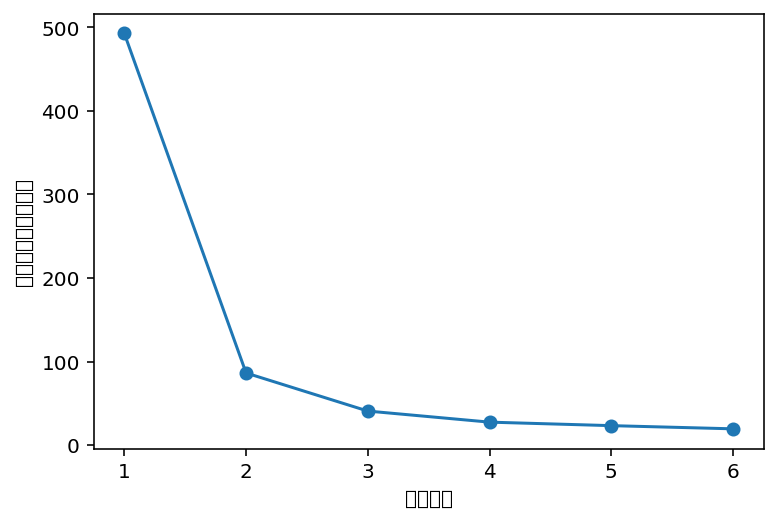

In [13]:
errors = []
for i in range(1,7):
    kms = KMeans(n_clusters=i)
    kms.fit(X, y)
    errors.append(kms.inertia_)
plt.plot(range(1,7), errors, marker='o')
plt.xlabel('集群數目')
plt.ylabel('集群內的誤差平方和');

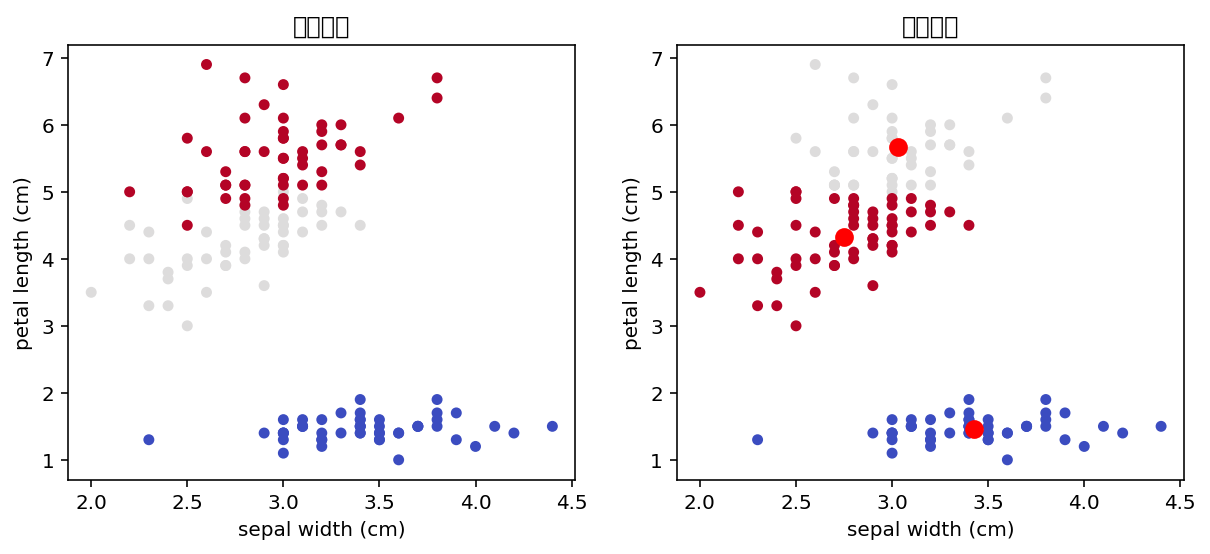

In [14]:
ks = KMeans(n_clusters=3)
ks.fit(X, y)
y_pred = ks.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df.plot(kind='scatter', x='sepal width (cm)', y='petal length (cm)', c='target',
       cmap='coolwarm', colorbar=False, ax=axes[0], title='原始資料')
df.plot(kind='scatter', x='sepal width (cm)', y='petal length (cm)', c=y_pred,
       cmap='coolwarm', colorbar=False, ax=axes[1], title='集群結果')
axes[1].scatter(ks.cluster_centers_[:,0], ks.cluster_centers_[:,1], s=70, c='red');

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=2)

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
model_pl = make_pipeline(KMeans(n_clusters=4), LogisticRegression())
model_pl.fit(X_train, y_train)
y_pred = model_pl.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
score = model_pl.score(X_test, y_test)
print('測試集的結果', score.round(3))
print(confusion_matrix(y_test, y_pred))
print('綜合報告')
print(classification_report(y_test, y_pred))

測試集的結果 0.956
[[17  0  0]
 [ 0 14  1]
 [ 0  1 12]]
綜合報告
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.93      0.93      0.93        15
           2       0.92      0.92      0.92        13

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



In [16]:
from sklearn.preprocessing import StandardScaler
model_pl_lr = make_pipeline(StandardScaler(), LogisticRegression())
model_pl_lr.fit(X_train, y_train)
y_pred = model_pl_lr.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[16  1  0]
 [ 0 14  1]
 [ 0  1 12]]
0.9333333333333333


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
class Kmeans_label(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def fit(self, X, y=None):
        self.model = KMeans(self.n_clusters).fit(X, y)
        return self
    
    def transform(self, X, y=None):
        return self.model.predict(X).reshape(-1, 1)
np.random.seed(42)
kms_l = Kmeans_label(n_clusters=4)
kms_l.fit(X_train, y_train)
kms_l.transform(X_train)[:5]

array([[2],
       [1],
       [0],
       [1],
       [1]], dtype=int32)

In [18]:
np.random.seed(42)
model_pl_lr = make_pipeline(Kmeans_label(3), LogisticRegression())
model_pl_lr.fit(X_train, y_train)
y_pred = model_pl_lr.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[17  0  0]
 [ 0 14  1]
 [ 0  3 10]]
0.9111111111111111
